In [ ]:
# CODE REVIEW FILE

# Imports

In [2]:
#general imports:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import scipy.interpolate as interp
import lalsimulation as lal
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
from keras import metrics
import keras_metrics as km


#gpu configuration:

gpu_num = 0

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

/home/braun2/anaconda3/envs/tf/lib/python3.8/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
2024-05-03 15:29:16.372836: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 15:29:16.414213: I tens

2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


2024-05-03 15:29:18.546106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46258 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-05-03 15:29:18.546601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46258 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


# Functions

format_output_EOS

In [2]:
# format_output is a function used to format a pandas DataFrame (data), with 5 titled columns, into 5 np arrays.
# the function is hardcoded to accept collumn titles of gamma0, gamma1, gamma2, logp1, and logp2. 


# input: dataframe with 5 collumns
# output: 5 np arrays--one of each column


def format_output_EOS(data):
    
    gamma0 = data['gamma0_norm'].to_numpy()
    #gamma0 = np.array(gamma0_norm)
    gamma1 = data['gamma1_norm'].to_numpy()
    #gamma1 = np.array(gamma1_norm)
    gamma2 = data['gamma2_norm'].to_numpy()
    #gamma2 = np.array(gamma2_norm)
    logp1_cgs_norm = data['logp1_cgs_norm'].to_numpy()
    #logp1_cgs_norm = np.array(logp1_cgs_norm)
    logp2_cgs_norm = data['logp2_cgs_norm'].to_numpy()
    #logp2_cgs_norm = np.array(logp2_cgs_norm)
    
    return gamma0, gamma1, gamma2, logp1_cgs_norm, logp2_cgs_norm

format_output_tidal

In [3]:
def format_output_tidal(data):
    
    m1 = data.pop('m1')
    m1 = np.array(m1)
    m2 = data.pop('m2')
    m2 = np.array(m2)
    l1 = data.pop('l1')
    l1 = np.array(l1)
    l2 = data.pop('l2')
    l2 = np.array(l2)
    
    return m1, m2, l1, l2

unnorm

In [4]:
# unorm is a function used to un-normalize the MLA outputs (predictions array) so they are plottable 
# with EOS functions. MLA values need to be un-normalizde given the MLA trains on normalized values and 
# thus outputs normalized values. The conversion from cgs to si is NOT done in this function. 

# the outputs are un-normalized with the following bounds:
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]
# log(p1) & p2 ∈ [33, 37], in cgs


# input: normalized predictions array
# output: un-normalized predictions array


def unnorm(predictionsarray):
    
    # un-normalizing the gammas and creating a seprate array for each
    new_gamma0_array = predictionsarray[0] * (5 - 1) + 1
    new_gamma1_array = predictionsarray[1] * (5 - 1) + 1
    new_gamma2_array = predictionsarray[2] * (5 - 1) + 1
     
    # creating a seprate array for logp1 and logp2, still in cgs units
    cgs_logp1 = predictionsarray[3] * (37 - 33) + 33
    cgs_logp2 = predictionsarray[4] * (37 - 33) + 33
    
    #concatenating each un-normalized array (reformats)
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, cgs_logp1, cgs_logp2), axis=1)
    
    return new_array

# Data Loading

In [5]:
l1_dat = np.loadtxt('updated_lambda_1.dat.txt', dtype=float)
l2_dat = np.loadtxt('updated_lambda_2.dat.txt', dtype=float)
m1_dat = np.loadtxt("updated_mass_1.dat", dtype=float)
m2_dat = np.loadtxt("updated_mass_2.dat", dtype=float)

gamma0 = np.loadtxt("updated_eos_polytrope_gamma_0.dat", dtype=float)
gamma1 = np.loadtxt("updated_eos_polytrope_gamma_1.dat", dtype=float)
gamma2 = np.loadtxt("updated_eos_polytrope_gamma_2.dat", dtype=float)
logp1_cgs = np.loadtxt("updated_eos_polytrope_log_pressure_1.dat", dtype=float) # in cgs
logp2_cgs = np.loadtxt("updated_eos_polytrope_log_pressure_2.dat", dtype=float) # in cgs

In [6]:
l1_dat, l2_dat

(array([4.85388596e+01, 4.26884333e+04, 1.67805410e+02, ...,
        9.03710244e+03, 3.06002938e+01, 5.13220069e+03]),
 array([  3153.62556257, 177501.9213599 ,    502.35724259, ...,
        343424.0911434 ,   4111.25096285,  10394.756243  ]))

# Preparing Data

In [7]:
datlen = 50000 #len(m1_dat)

Creating an empty array

In [8]:
# (24) x (total num of samples in one array) to fill with data.
# the first 9 collumns are for m1, m2, l1, l2, gamma0, gamma1, gamma2, logp1_cgs, and logp2_cgs
# the next 5 are for gamma0_norm, gamma1_norm, gamma2_norm, logp1_cgs_norm, and logp2_cgs_norm
# the next 5 are for gamma0_norm_predicted, gamma1_norm_predicted, gamma2_norm_predicted, logp1_cgs_norm_predicted, and logp2_cgs_norm_predicted
# the final 5 are for gamma0_predicted, gamma1_predicted, gamma2_predicted, logp1_cgs_predicted, and logp2_cgs_predicted

numcol = 24 

array_size =  np.array([[0] * numcol ] * datlen,dtype='float64')
#array_size = array_size.astype('float64')
#combined_array = np.zeros_like(array_size)

Creating an empty pandas dataframe of the same shape as combined_array

In [60]:
data = pd.DataFrame(array_size)

data.columns = ['m1', 'm2', 'l1', 'l2', 'gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2', 'gamma0_norm', 'logp1_cgs_norm', 'gamma1_norm', 'logp2_cgs_norm', 'gamma2_norm', 'gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted', 'gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted','logp2_cgs_predicted', 'gamma2_predicted']


In [61]:
data

m1   m2   l1   l2  gamma0  logp1_cgs  gamma1  logp2_cgs  gamma2  \
0      0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
1      0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
2      0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
3      0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
4      0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
...    ...  ...  ...  ...     ...        ...     ...        ...     ...   
49995  0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
49996  0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
49997  0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
49998  0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   
49999  0.0  0.0  0.0  0.0     0.0        0.0     0.0        0.0     0.0   

       gamma0_norm  logp1_cgs_norm  gamma1_norm  logp2_cgs_norm  gamma2_norm  \
0              0.0             0.0          0.0             0.0          0.0   
1              0.0             0.0          0.0             0.0          0.0   
2              0.0             0.0          0.0             0.0          0.0   
3              0.0             0.0          0.0             0.0          0.0   
4              0.0             0.0          0.0             0.0          0.0   
...            ...             ...          ...             ...          ...   
49995          0.0             0.0          0.0             0.0          0.0   
49996          0.0             0.0          0.0             0.0          0.0   
49997          0.0             0.0          0.0             0.0          0.0   
49998          0.0             0.0          0.0             0.0          0.0   
49999          0.0             0.0          0.0             0.0          0.0   

       gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                        0.0                       0.0                    0.0   
1                        0.0                       0.0                    0.0   
2                        0.0                       0.0                    0.0   
3                        0.0                       0.0                    0.0   
4                        0.0                       0.0                    0.0   
...                      ...                       ...                    ...   
49995                    0.0                       0.0                    0.0   
49996                    0.0                       0.0                    0.0   
49997                    0.0                       0.0                    0.0   
49998                    0.0                       0.0                    0.0   
49999                    0.0                       0.0                    0.0   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                           0.0                    0.0               0.0   
1                           0.0                    0.0               0.0   
2                           0.0                    0.0               0.0   
3                           0.0                    0.0               0.0   
4                           0.0                    0.0               0.0   
...                         ...                    ...               ...   
49995                       0.0                    0.0               0.0   
49996                       0.0                    0.0               0.0   
49997                       0.0                    0.0               0.0   
49998                       0.0                    0.0               0.0   
49999                       0.0                    0.0               0.0   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                      0.0               0.0                  0.0   
1                      0.0               0.0                  0.0   
2                      0.0               0.0         

Inserting known data into first 9 collumns

In [62]:
data['m1'] = m1_dat[0:datlen]
data['m2'] = m2_dat[0:datlen]
data['l1'] = l1_dat[0:datlen]
data['l2'] = l2_dat[0:datlen]
data['gamma0'] = gamma0[0:datlen]
data['gamma1'] = gamma1[0:datlen]
data['gamma2'] = gamma2[0:datlen]
data['logp1_cgs'] = logp1_cgs[0:datlen]
data['logp2_cgs'] = logp2_cgs[0:datlen]

Normalizing all data that will be MLA outputs (gammas and logp's) to be between 0 and 1

In [63]:
#fix me: make a function (?)

# bounds:
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]
# log(p1) & p2 ∈ [33, 37], in cgs

gamma0_norm = (gamma0 - 1)/(5 - 1)
gamma1_norm = (gamma1 - 1)/(5 - 1)
gamma2_norm = (gamma2 - 1)/(5 - 1)

logp1_cgs_norm = ((logp1_cgs) - (33))/((37) - (33))
logp2_cgs_norm = ((logp2_cgs) - (33))/((37) - (33))

Inserting normalized data into following 5 collumns

In [68]:
data['gamma0_norm'] = gamma0_norm[0:datlen]
data['gamma1_norm'] = gamma1_norm[0:datlen]
data['gamma2_norm'] = gamma2_norm[0:datlen]
data['logp1_cgs_norm'] = logp1_cgs_norm[0:datlen]
data['logp2_cgs_norm'] = logp2_cgs_norm[0:datlen]

In [69]:
data

m1        m2            l1             l2    gamma0  logp1_cgs  \
0      1.971465  1.087328     48.538860    3153.625563  2.749811  35.365482   
1      0.917844  0.664838  42688.433302  177501.921360  3.595422  34.654207   
2      2.535693  2.119748    167.805410     502.357243  3.520350  35.396764   
3      0.876440  0.544662  48488.884176  448183.326755  2.917128  35.255684   
4      4.092187  3.754260     51.173074      92.106467  4.252634  34.932686   
...         ...       ...           ...            ...       ...        ...   
49995  1.727422  1.369300   6448.234563   18129.531837  3.791754  33.440527   
49996  0.699108  0.655327  79178.345326  109554.321745  2.362006  33.940821   
49997  2.186413  1.630084   3175.028837   12511.638716  3.293796  33.026767   
49998  1.116031  0.842207  19935.240905   66718.520264  4.598794  35.306336   
49999  3.658143  0.849222     80.625209   91693.864374  4.750452  34.792232   

         gamma1  logp2_cgs    gamma2  gamma0_norm  logp1_cgs_norm  \
0      4.163723  35.765971  1.138051     0.437453        0.591370   
1      3.981949  34.993765  1.593887     0.648856        0.413552   
2      4.952541  36.017062  1.272790     0.630087        0.599191   
3      1.149857  36.029744  1.967677     0.479282        0.563921   
4      3.321473  35.708051  1.456522     0.813159        0.483171   
...         ...        ...       ...          ...             ...   
49995  4.773079  36.900283  1.091320     0.697939        0.110132   
49996  2.777913  34.595926  1.535013     0.340501        0.235205   
49997  4.130634  34.994576  2.092221     0.573449        0.006692   
49998  3.806648  35.632485  1.049226     0.899699        0.576584   
49999  4.234088  35.206430  1.144645     0.937613        0.448058   

       gamma1_norm  logp2_cgs_norm  gamma2_norm  gamma0_norm_predicted  \
0         0.790931        0.691493     0.034513                    0.0   
1         0.745487        0.498441     0.148472                    0.0   
2         0.988135        0.754266     0.068198                    0.0   
3         0.037464        0.757436     0.241919                    0.0   
4         0.580368        0.677013     0.114131                    0.0   
...            ...             ...          ...                    ...   
49995     0.943270        0.975071     0.022830                    0.0   
49996     0.444478        0.398982     0.133753                    0.0   
49997     0.782659        0.498644     0.273055                    0.0   
49998     0.701662        0.658121     0.012307                    0.0   
49999     0.808522        0.551607     0.036161                    0.0   

       logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                           0.0                    0.0   
1                           0.0                    0.0   
2                           0.0                    0.0   
3                           0.0                    0.0   
4                           0.0                    0.0   
...                         ...                    ...   
49995                       0.0                    0.0   
49996                       0.0                    0.0   
49997                       0.0                    0.0   
49998                       0.0                    0.0   
49999                       0.0                    0.0   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                           0.0                    0.0               0.0   
1                           0.0                    0.0               0.0   
2                           0.0                    0.0               0.0   
3                           0.0                    0.0               0.0   
4                           0.0                    0.0               0.0   
...                         ...                    ...               ...   
49995                       0.0                    0.0               0.0   
49996                       0.0          

# Sanity-Checking Data

Histograming imported data prior to normalization 

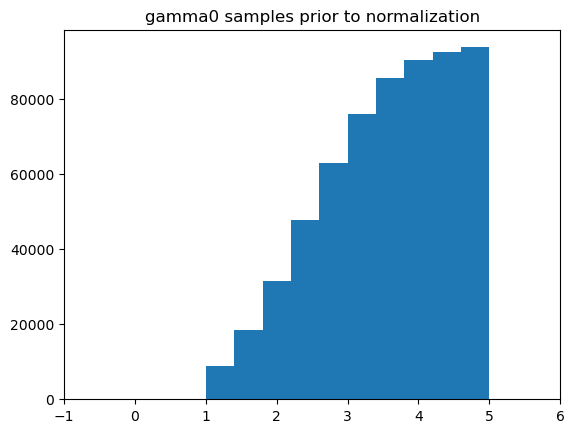

In [15]:
#gamma0
plt.hist(gamma0)
plt.title("gamma0 samples prior to normalization")
plt.xlim(-1, 6)
plt.show()

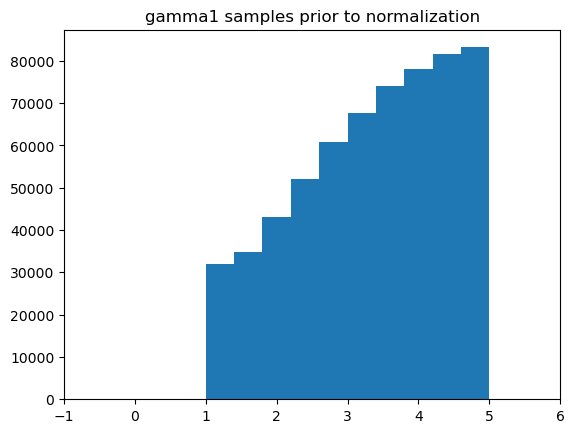

In [16]:
#gamma1
plt.hist(gamma1)
plt.title("gamma1 samples prior to normalization")
plt.xlim(-1, 6)
plt.show()

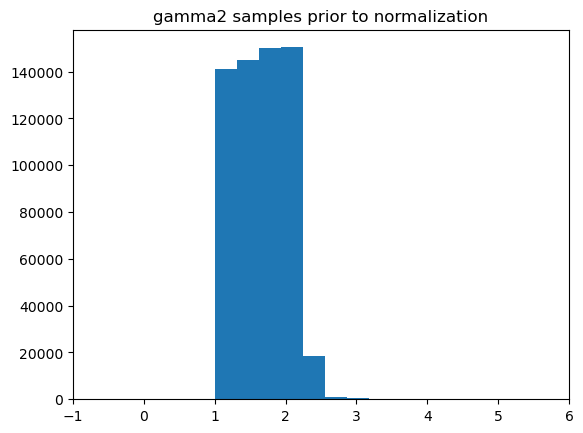

In [17]:
#gamma2
plt.hist(gamma2)
plt.title("gamma2 samples prior to normalization")
plt.xlim(-1, 6)
plt.show()

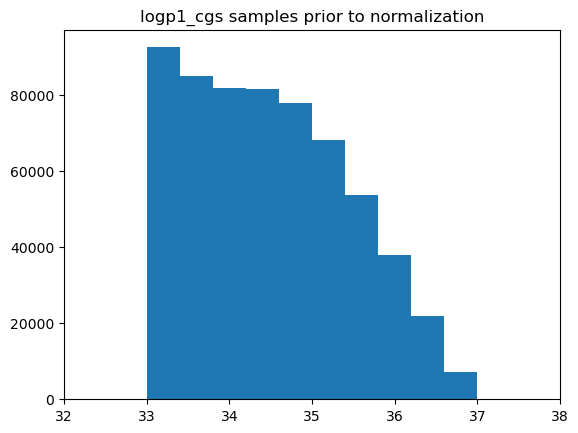

In [18]:
#logp1
plt.hist(logp1_cgs)
plt.title("logp1_cgs samples prior to normalization")
plt.xlim(32.0, 38.0)
plt.show()

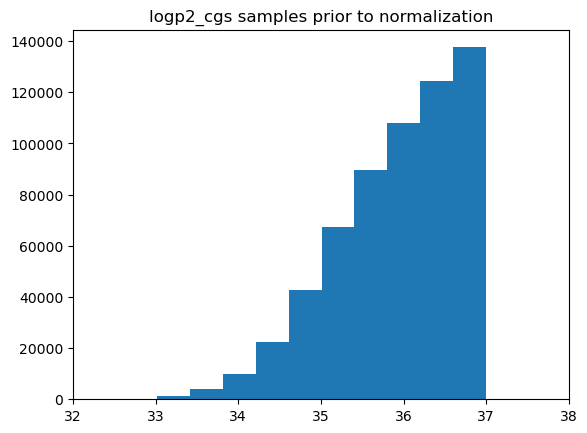

In [19]:
#logp2
plt.hist(logp2_cgs)
plt.title("logp2_cgs samples prior to normalization")
plt.xlim(32.0, 38.0)
plt.show()

Histograming imported data after to normalization 

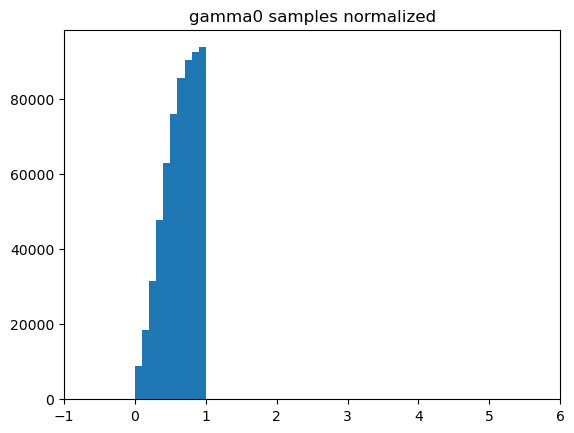

In [20]:
#gamma0
plt.hist(gamma0_norm)
plt.title("gamma0 samples normalized")
plt.xlim(-1, 6)
plt.show()

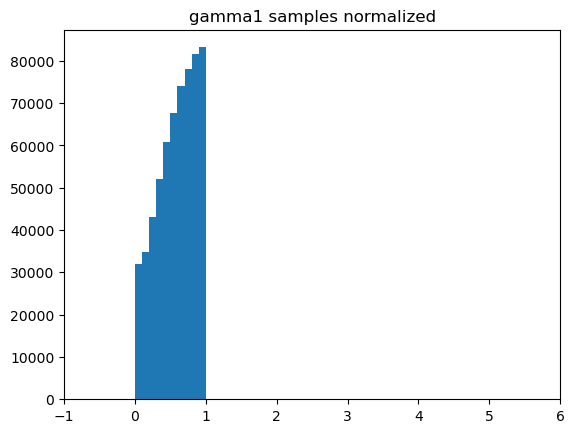

In [21]:
#gamma1
plt.hist(gamma1_norm)
plt.title("gamma1 samples normalized")
plt.xlim(-1, 6)
plt.show()

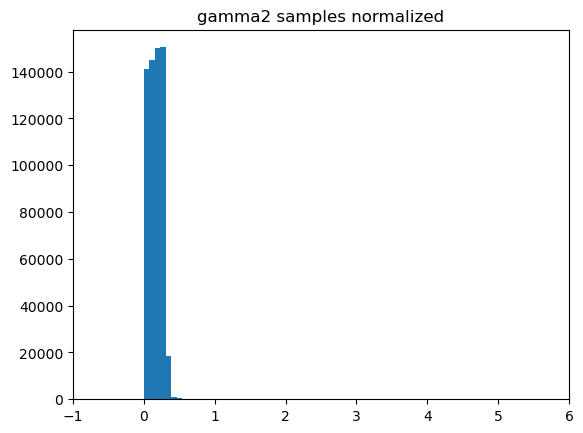

In [22]:
#gamma2
plt.hist(gamma2_norm)
plt.title("gamma2 samples normalized")
plt.xlim(-1, 6)
plt.show()

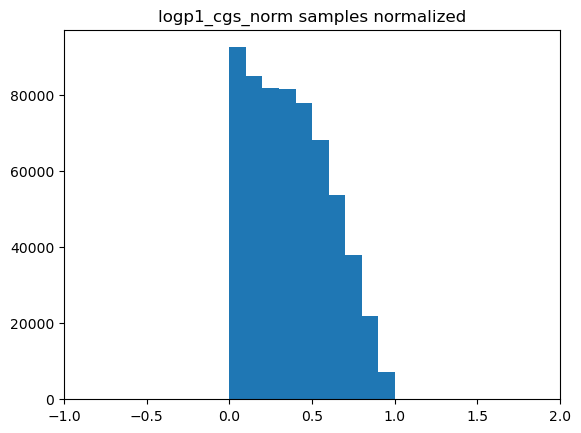

In [23]:
#logp1
plt.hist(logp1_cgs_norm)
plt.title("logp1_cgs_norm samples normalized")
plt.xlim(-1, 2)
plt.show()

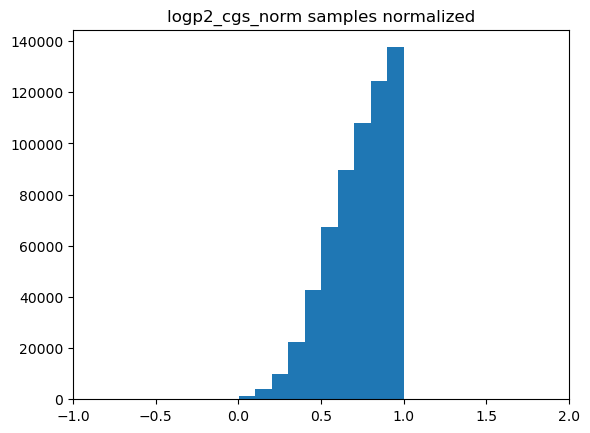

In [24]:
#logp2
plt.hist(logp2_cgs_norm)
plt.title("logp2_cgs_norm samples normalized")
plt.xlim(-1, 2)
plt.show()

# MLA Construction

Splitting the data into train and test and creating the input train & test arrays

In [70]:
# 541 total samples: 80% = 432, 20% = 108.2

# for train and test ONLY:
# we want the first 432 samples to = train
# we want the last 109 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index

trainsplit = .8

train = data.iloc[:int(datlen*trainsplit),:]
test = data.iloc[int(datlen*trainsplit):,:]

print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

Shape of new dataframes - (40000, 24) , (10000, 24)


In [71]:
train

m1        m2            l1             l2    gamma0  logp1_cgs  \
0      1.971465  1.087328     48.538860    3153.625563  2.749811  35.365482   
1      0.917844  0.664838  42688.433302  177501.921360  3.595422  34.654207   
2      2.535693  2.119748    167.805410     502.357243  3.520350  35.396764   
3      0.876440  0.544662  48488.884176  448183.326755  2.917128  35.255684   
4      4.092187  3.754260     51.173074      92.106467  4.252634  34.932686   
...         ...       ...           ...            ...       ...        ...   
39995  1.400870  1.209929   4891.596113   10152.975034  2.657670  33.714819   
39996  4.663976  3.428299     16.372646     141.219499  1.880925  33.062721   
39997  3.786408  1.956922     48.060133    3049.045319  4.440348  33.642814   
39998  4.224817  2.262841     93.751394    2737.210672  4.376669  35.321049   
39999  1.213802  0.858380     83.024174    3271.390533  3.253341  33.032072   

         gamma1  logp2_cgs    gamma2  gamma0_norm  logp1_cgs_norm  \
0      4.163723  35.765971  1.138051     0.437453        0.591370   
1      3.981949  34.993765  1.593887     0.648856        0.413552   
2      4.952541  36.017062  1.272790     0.630087        0.599191   
3      1.149857  36.029744  1.967677     0.479282        0.563921   
4      3.321473  35.708051  1.456522     0.813159        0.483171   
...         ...        ...       ...          ...             ...   
39995  3.329830  35.204300  2.271048     0.414417        0.178705   
39996  4.471855  36.142704  2.060406     0.220231        0.015680   
39997  3.203888  36.659855  1.149921     0.860087        0.160703   
39998  2.195721  35.461695  1.323165     0.844167        0.580262   
39999  1.825505  33.145117  2.069029     0.563335        0.008018   

       gamma1_norm  logp2_cgs_norm  gamma2_norm  gamma0_norm_predicted  \
0         0.790931        0.691493     0.034513                    0.0   
1         0.745487        0.498441     0.148472                    0.0   
2         0.988135        0.754266     0.068198                    0.0   
3         0.037464        0.757436     0.241919                    0.0   
4         0.580368        0.677013     0.114131                    0.0   
...            ...             ...          ...                    ...   
39995     0.582457        0.551075     0.317762                    0.0   
39996     0.867964        0.785676     0.265102                    0.0   
39997     0.550972        0.914964     0.037480                    0.0   
39998     0.298930        0.615424     0.080791                    0.0   
39999     0.206376        0.036279     0.267257                    0.0   

       logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                           0.0                    0.0   
1                           0.0                    0.0   
2                           0.0                    0.0   
3                           0.0                    0.0   
4                           0.0                    0.0   
...                         ...                    ...   
39995                       0.0                    0.0   
39996                       0.0                    0.0   
39997                       0.0                    0.0   
39998                       0.0                    0.0   
39999                       0.0                    0.0   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                           0.0                    0.0               0.0   
1                           0.0                    0.0               0.0   
2                           0.0                    0.0               0.0   
3                           0.0                    0.0               0.0   
4                           0.0                    0.0               0.0   
...                         ...                    ...               ...   
39995                       0.0                    0.0               0.0   
39996                       0.0          

Train statistics

In [72]:
train_stats = train.describe()
train_stats = train_stats.transpose()
(train_stats)

count          mean           std           min  \
m1                        40000.0  2.427718e+00  1.128738e+00  5.050142e-01   
m2                        40000.0  1.614196e+00  8.997240e-01  5.000201e-01   
l1                        40000.0 -1.024525e+12  1.343933e+15 -1.370632e+17   
l2                        40000.0  2.646194e+13  6.299726e+15 -2.786480e+17   
gamma0                    40000.0  3.561942e+00  9.442234e-01  1.000319e+00   
logp1_cgs                 40000.0  3.448711e+01  9.556278e-01  3.300003e+01   
gamma1                    40000.0  3.348441e+00  1.078490e+00  1.000471e+00   
logp2_cgs                 40000.0  3.593216e+01  7.589256e-01  3.305782e+01   
gamma2                    40000.0  1.654598e+00  3.788182e-01  1.000048e+00   
gamma0_norm               40000.0  6.404856e-01  2.360558e-01  7.982410e-05   
logp1_cgs_norm            40000.0  3.717763e-01  2.389070e-01  6.380355e-06   
gamma1_norm               40000.0  5.871102e-01  2.696226e-01  1.176579e-04   
logp2_cgs_norm            40000.0  7.330409e-01  1.897314e-01  1.445481e-02   
gamma2_norm               40000.0  1.636494e-01  9.470455e-02  1.188460e-05   
gamma0_norm_predicted     40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
logp1_cgs_norm_predicted  40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
gamma1_norm_predicted     40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
logp2_cgs_norm_predicted  40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
gamma2_norm_predicted     40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
gamma0_predicted          40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
logp1_cgs_predicted       40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
gamma1_predicted          40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
logp2_cgs_predicted       40000.0  0.000000e+00  0.000000e+00  0.000000e+00   
gamma2_predicted          40000.0  0.000000e+00  0.000000e+00  0.000000e+00   

                                  25%          50%           75%           max  
m1                           1.488951     2.279726      3.270313  4.999446e+00  
m2                           0.891575     1.374136      2.134369  4.992831e+00  
l1                          94.960428   580.493369   4636.084279  1.050388e+17  
l2                        1113.075740  8584.185753  59028.184030  1.208339e+18  
gamma0                       2.886234     3.676841      4.358003  4.999993e+00  
logp1_cgs                   33.678635    34.400375     35.203240  3.699295e+01  
gamma1                       2.536709     3.477250      4.259350  4.999965e+00  
logp2_cgs                   35.428191    36.058739     36.560895  3.699996e+01  
gamma2                       1.336119     1.657303      1.969795  4.012067e+00  
gamma0_norm                  0.471558     0.669210      0.839501  9.999983e-01  
logp1_cgs_norm               0.169659     0.350094      0.550810  9.982375e-01  
gamma1_norm                  0.384177     0.619312      0.814837  9.999913e-01  
logp2_cgs_norm               0.607048     0.764685      0.890224  9.999910e-01  
gamma2_norm                  0.084030     0.164326      0.242449  7.530167e-01  
gamma0_norm_predicted        0.000000     0.000000      0.000000  0.000000e+00  
logp1_cgs_norm_predicted     0.000000     0.000000      0.000000  0.000000e+00  
gamma1_norm_predicted        0.000000     0.000000      0.000000  0.000000e+00  
logp2_cgs_norm_predicted     0.000000     0.000000      0.000000  0.000000e+00  
gamma2_norm_predicted        0.000000     0.000000      0.000000  0.000000e+00  
gamma0_predicted             0.000000     0.000000      0.000000  0.000000e+00  
logp1_cgs_predicted          0.000000     0.000000      0.000000  0.000000e+00  
gamma1_predicted             0.000000     0.000000      0.000000  0.000000e+00  
logp2_cgs_predicted          0.000000     0.000000      0.000000  0.000000e+00  
gamma2_predicted             0.000000     0.000000      0.000000  0.000000e+00

Creating output train & test arrays that can be inputted into the MLA

In [73]:
selected_train_Y = train[['gamma0_norm', 'gamma1_norm', 'gamma2_norm', 'logp1_cgs_norm', 'logp2_cgs_norm']]
train_Y = format_output_EOS(selected_train_Y)

In [74]:
train_X = train[['m1', 'm2', 'l1', 'l2']].to_numpy()

In [75]:
selected_test_Y = test[['gamma0_norm', 'gamma1_norm', 'gamma2_norm', 'logp1_cgs_norm', 'logp2_cgs_norm']].copy()
test_Y = format_output_EOS(selected_test_Y)

In [76]:
test_X = test[['m1', 'm2', 'l1', 'l2']].to_numpy()

Creating the MLA structure (adding layers)

In [77]:
input_layer = Input(shape=(len(train_X[0]),))

#tanh and sigmoid are selected for their capabilies in relation to the expected outputs of the MLA

layeract = 'tanh'
outputact = 'sigmoid' #nonlinear? look into

first_dense = Dense(units='128', activation=layeract)(input_layer)
second_dense = Dense(units='128', activation=layeract)(first_dense)
third_dense = Dense(units='128', activation=layeract)(second_dense)
fourth_dense = Dense(units='128', activation=layeract)(third_dense)
fifth_dense = Dense(units='128', activation=layeract)(fourth_dense)
sixth_dense = Dense(units='128', activation=layeract)(fifth_dense)
seventh_dense = Dense(units='128', activation=layeract)(sixth_dense)
eight_dense = Dense(units='128', activation=layeract)(seventh_dense)
ninth_dense = Dense(units='128', activation=layeract)(eight_dense)
    
tenth_dense = Dense(units='128', activation=layeract)(ninth_dense)
eleventh_dense = Dense(units='128', activation=layeract)(tenth_dense)
twelth_dense = Dense(units='128', activation=layeract)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=layeract)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=layeract)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=layeract)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=layeract)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=layeract)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=layeract)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=layeract)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=layeract)(nineteenth_dense)
tf_dense = Dense(units='128', activation=layeract)(twentieth_dense)
ts_dense = Dense(units='128', activation=layeract)(tf_dense)
tt_dense = Dense(units='128', activation=layeract)(ts_dense)
tfo_dense = Dense(units='128', activation=layeract)(tt_dense)
tfi_dense = Dense(units='128', activation=layeract)(tfo_dense)
ts_dense = Dense(units='128', activation=layeract)(tfi_dense)
tse_dense = Dense(units='128', activation=layeract)(ts_dense)
te_dense = Dense(units='128', activation=layeract)(tse_dense)
tn_dense = Dense(units='128', activation=layeract)(te_dense)


gamma0_norm_output = Dense(units='1', activation=outputact, name='gamma0_norm_output')(tn_dense)
thf_dense = Dense(units='64', activation=layeract)(tn_dense)

ths_dense = Dense(units='64', activation=layeract)(thf_dense)
tht_dense = Dense(units='64', activation=layeract)(ths_dense)
thfo_dense = Dense(units='64', activation=layeract)(tht_dense)
thfi_dense = Dense(units='64', activation=layeract)(thfo_dense)
ths_dense = Dense(units='64', activation=layeract)(thfi_dense)
thse_dense = Dense(units='64', activation=layeract)(ths_dense)
the_dense = Dense(units='64', activation=layeract)(thse_dense)
thn_dense = Dense(units='64', activation=layeract)(the_dense)


logp1_cgs_norm_output = Dense(units='1', activation=outputact, name='logp1_cgs_norm_output')(thn_dense)
fo_dense = Dense(units='32',activation=layeract)(thn_dense)

fof_dense = Dense(units='32', activation=layeract)(fo_dense)
fos_dense = Dense(units='32', activation=layeract)(fof_dense)
fot_dense = Dense(units='32', activation=layeract)(fos_dense)
fofo_dense = Dense(units='32', activation=layeract)(fot_dense)
fofi_dense = Dense(units='32', activation=layeract)(fofo_dense)

gamma1_norm_output = Dense(units='1', activation=outputact, name='gamma1_norm_output')(fofi_dense)
fos_dense = Dense(units='16',activation=layeract)(fofi_dense)

fose_dense = Dense(units='16', activation=layeract)(fos_dense)
foe_dense = Dense(units='16', activation=layeract)(fose_dense)
fon_dense = Dense(units='16', activation=layeract)(foe_dense)
fif_dense = Dense(units='16', activation=layeract)(fon_dense)


logp2_cgs_norm_output = Dense(units='1', activation=outputact, name='logp2_cgs_norm_output')(fif_dense)
fiff_dense = Dense(units='8', activation=layeract)(fif_dense)

fifs_dense = Dense(units='8', activation=layeract)(fiff_dense)
fift_dense = Dense(units='8', activation=layeract)(fifs_dense)
fiff_dense = Dense(units='8', activation=layeract)(fift_dense)
fiffi_dense = Dense(units='8', activation=layeract)(fiff_dense)
fifs_dense = Dense(units='8', activation=layeract)(fiffi_dense)

gamma2_norm_output = Dense(units='1', activation=outputact, name='gamma2_norm_output')(fifs_dense)

s1_dense = Dense(units='8', activation=layeract)(fifs_dense)
s2_dense = Dense(units='8', activation=layeract)(s1_dense)
s3_dense = Dense(units='8', activation=layeract)(s2_dense)


logp2_cgs_norm_output = Dense(units='1', activation=outputact, name='logp2_cgs_norm_output')(s3_dense)
s4_dense = Dense(units='8', activation=layeract)(s3_dense)
s5_dense = Dense(units='8', activation=layeract)(s4_dense)

gamma1_norm_output = Dense(units='1', activation=outputact, name='gamma1_norm_output')(s5_dense)
s6_dense = Dense(units='8', activation=layeract)(s5_dense)
s7_dense = Dense(units='8', activation=layeract)(s6_dense)

logp1_cgs_norm_output = Dense(units='1', activation=outputact, name='logp1_cgs_norm_output')(s7_dense)
s8_dense = Dense(units='8', activation=layeract)(s7_dense)
s9_dense = Dense(units='8', activation=layeract)(s8_dense)

gamma0_norm_output = Dense(units='1', activation=outputact, name='gamma0_norm_output')(s9_dense)
#s10_dense = Dense(units='8', activation=layeract)(s9_dense)
#s11_dense = Dense(units='8', activation=layeract)(s10_dense)


model = Model(inputs=input_layer, outputs=[gamma0_norm_output, logp1_cgs_norm_output, gamma1_norm_output, logp2_cgs_norm_output, gamma2_norm_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense_64 (Dense)            (None, 128)                  640       ['input_2[0][0]']             
                                                                                                  
 dense_65 (Dense)            (None, 128)                  16512     ['dense_64[0][0]']            
                                                                                                  
 dense_66 (Dense)            (None, 128)                  16512     ['dense_65[0][0]']            
                                                                                            

 dense_103 (Dense)           (None, 32)                   1056      ['dense_102[0][0]']           
                                                                                                  
 dense_104 (Dense)           (None, 32)                   1056      ['dense_103[0][0]']           
                                                                                                  
 dense_105 (Dense)           (None, 32)                   1056      ['dense_104[0][0]']           
                                                                                                  
 dense_106 (Dense)           (None, 32)                   1056      ['dense_105[0][0]']           
                                                                                                  
 dense_107 (Dense)           (None, 32)                   1056      ['dense_106[0][0]']           
                                                                                                  
 dense_108

Specifying the optimizer as stochastic gradient descent and learning rate as 0.001, as well as compiling the model with loss metrics

In [79]:
#the mean squared error loss is chosen for this MLA as it us compatable with the ANN

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_norm_output': 'mse', 'logp1_cgs_norm_output': 'mse', 'gamma1_norm_output': 'mse', 'logp2_cgs_norm_output': 'mse', 'gamma2_norm_output': 'mse'},
              metrics={
                       'gamma0_norm_output': tf.keras.metrics.MeanSquaredError() ,
                      'logp1_cgs_norm_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma1_norm_output': tf.keras.metrics.MeanSquaredError(),
                      'logp2_cgs_norm_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_norm_output': tf.keras.metrics.MeanSquaredError()
                      })

#this string is saved for later, when plotting loss. 
endmetric = "mean_squared_error"

# MLA Training

In [80]:
#train the model for a number of epochs
#fix me: for the future, hyper-parameter tune

numepochs = 100
    
history = model.fit(train_X, train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=15,mode='auto')])


Epoch 1/100
3200/3200 [==============================] - 40s 9ms/step - loss: 0.2410 - gamma0_norm_output_loss: 0.0570 - logp1_cgs_norm_output_loss: 0.0728 - gamma1_norm_output_loss: 0.0135 - logp2_cgs_norm_output_loss: 0.0579 - gamma2_norm_output_loss: 0.0398 - gamma0_norm_output_mean_squared_error: 0.0570 - logp1_cgs_norm_output_mean_squared_error: 0.0728 - gamma1_norm_output_mean_squared_error: 0.0135 - logp2_cgs_norm_output_mean_squared_error: 0.0579 - gamma2_norm_output_mean_squared_error: 0.0398 - val_loss: 0.2296 - val_gamma0_norm_output_loss: 0.0542 - val_logp1_cgs_norm_output_loss: 0.0733 - val_gamma1_norm_output_loss: 0.0091 - val_logp2_cgs_norm_output_loss: 0.0571 - val_gamma2_norm_output_loss: 0.0360 - val_gamma0_norm_output_mean_squared_error: 0.0542 - val_logp1_cgs_norm_output_mean_squared_error: 0.0733 - val_gamma1_norm_output_mean_squared_error: 0.0091 - val_logp2_cgs_norm_output_mean_squared_error: 0.0571 - val_gamma2_norm_output_mean_squared_error: 0.0360
Epoch 2/100


3200/3200 [==============================] - 30s 9ms/step - loss: 0.2305 - gamma0_norm_output_loss: 0.0561 - logp1_cgs_norm_output_loss: 0.0725 - gamma1_norm_output_loss: 0.0090 - logp2_cgs_norm_output_loss: 0.0571 - gamma2_norm_output_loss: 0.0359 - gamma0_norm_output_mean_squared_error: 0.0561 - logp1_cgs_norm_output_mean_squared_error: 0.0725 - gamma1_norm_output_mean_squared_error: 0.0090 - logp2_cgs_norm_output_mean_squared_error: 0.0571 - gamma2_norm_output_mean_squared_error: 0.0359 - val_loss: 0.2294 - val_gamma0_norm_output_loss: 0.0541 - val_logp1_cgs_norm_output_loss: 0.0732 - val_gamma1_norm_output_loss: 0.0091 - val_logp2_cgs_norm_output_loss: 0.0571 - val_gamma2_norm_output_loss: 0.0360 - val_gamma0_norm_output_mean_squared_error: 0.0541 - val_logp1_cgs_norm_output_mean_squared_error: 0.0732 - val_gamma1_norm_output_mean_squared_error: 0.0091 - val_logp2_cgs_norm_output_mean_squared_error: 0.0571 - val_gamma2_norm_output_mean_squared_error: 0.0360
Epoch 10/100
3200/3200 [

3200/3200 [==============================] - 29s 9ms/step - loss: 0.2306 - gamma0_norm_output_loss: 0.0558 - logp1_cgs_norm_output_loss: 0.0726 - gamma1_norm_output_loss: 0.0090 - logp2_cgs_norm_output_loss: 0.0571 - gamma2_norm_output_loss: 0.0360 - gamma0_norm_output_mean_squared_error: 0.0558 - logp1_cgs_norm_output_mean_squared_error: 0.0726 - gamma1_norm_output_mean_squared_error: 0.0090 - logp2_cgs_norm_output_mean_squared_error: 0.0571 - gamma2_norm_output_mean_squared_error: 0.0360 - val_loss: 0.2294 - val_gamma0_norm_output_loss: 0.0540 - val_logp1_cgs_norm_output_loss: 0.0732 - val_gamma1_norm_output_loss: 0.0091 - val_logp2_cgs_norm_output_loss: 0.0571 - val_gamma2_norm_output_loss: 0.0360 - val_gamma0_norm_output_mean_squared_error: 0.0540 - val_logp1_cgs_norm_output_mean_squared_error: 0.0732 - val_gamma1_norm_output_mean_squared_error: 0.0091 - val_logp2_cgs_norm_output_mean_squared_error: 0.0571 - val_gamma2_norm_output_mean_squared_error: 0.0360
Epoch 18/100
3200/3200 [

3200/3200 [==============================] - 28s 9ms/step - loss: 0.2295 - gamma0_norm_output_loss: 0.0559 - logp1_cgs_norm_output_loss: 0.0721 - gamma1_norm_output_loss: 0.0090 - logp2_cgs_norm_output_loss: 0.0570 - gamma2_norm_output_loss: 0.0355 - gamma0_norm_output_mean_squared_error: 0.0559 - logp1_cgs_norm_output_mean_squared_error: 0.0721 - gamma1_norm_output_mean_squared_error: 0.0090 - logp2_cgs_norm_output_mean_squared_error: 0.0570 - gamma2_norm_output_mean_squared_error: 0.0355 - val_loss: 0.2290 - val_gamma0_norm_output_loss: 0.0543 - val_logp1_cgs_norm_output_loss: 0.0729 - val_gamma1_norm_output_loss: 0.0091 - val_logp2_cgs_norm_output_loss: 0.0572 - val_gamma2_norm_output_loss: 0.0356 - val_gamma0_norm_output_mean_squared_error: 0.0543 - val_logp1_cgs_norm_output_mean_squared_error: 0.0729 - val_gamma1_norm_output_mean_squared_error: 0.0091 - val_logp2_cgs_norm_output_mean_squared_error: 0.0572 - val_gamma2_norm_output_mean_squared_error: 0.0356
Epoch 26/100
3200/3200 [

3200/3200 [==============================] - 28s 9ms/step - loss: 0.2296 - gamma0_norm_output_loss: 0.0558 - logp1_cgs_norm_output_loss: 0.0722 - gamma1_norm_output_loss: 0.0090 - logp2_cgs_norm_output_loss: 0.0570 - gamma2_norm_output_loss: 0.0356 - gamma0_norm_output_mean_squared_error: 0.0558 - logp1_cgs_norm_output_mean_squared_error: 0.0722 - gamma1_norm_output_mean_squared_error: 0.0090 - logp2_cgs_norm_output_mean_squared_error: 0.0570 - gamma2_norm_output_mean_squared_error: 0.0356 - val_loss: 0.2289 - val_gamma0_norm_output_loss: 0.0542 - val_logp1_cgs_norm_output_loss: 0.0731 - val_gamma1_norm_output_loss: 0.0091 - val_logp2_cgs_norm_output_loss: 0.0570 - val_gamma2_norm_output_loss: 0.0356 - val_gamma0_norm_output_mean_squared_error: 0.0542 - val_logp1_cgs_norm_output_mean_squared_error: 0.0731 - val_gamma1_norm_output_mean_squared_error: 0.0091 - val_logp2_cgs_norm_output_mean_squared_error: 0.0570 - val_gamma2_norm_output_mean_squared_error: 0.0356
Epoch 34/100
3200/3200 [

3200/3200 [==============================] - 28s 9ms/step - loss: 0.2287 - gamma0_norm_output_loss: 0.0555 - logp1_cgs_norm_output_loss: 0.0719 - gamma1_norm_output_loss: 0.0090 - logp2_cgs_norm_output_loss: 0.0570 - gamma2_norm_output_loss: 0.0354 - gamma0_norm_output_mean_squared_error: 0.0555 - logp1_cgs_norm_output_mean_squared_error: 0.0719 - gamma1_norm_output_mean_squared_error: 0.0090 - logp2_cgs_norm_output_mean_squared_error: 0.0570 - gamma2_norm_output_mean_squared_error: 0.0354 - val_loss: 0.2282 - val_gamma0_norm_output_loss: 0.0541 - val_logp1_cgs_norm_output_loss: 0.0728 - val_gamma1_norm_output_loss: 0.0091 - val_logp2_cgs_norm_output_loss: 0.0569 - val_gamma2_norm_output_loss: 0.0353 - val_gamma0_norm_output_mean_squared_error: 0.0541 - val_logp1_cgs_norm_output_mean_squared_error: 0.0728 - val_gamma1_norm_output_mean_squared_error: 0.0091 - val_logp2_cgs_norm_output_mean_squared_error: 0.0569 - val_gamma2_norm_output_mean_squared_error: 0.0353
Epoch 42/100
3200/3200 [

In [81]:
train_X

array([[1.97146492e+00, 1.08732829e+00, 4.85388596e+01, 3.15362556e+03],
       [9.17843669e-01, 6.64838041e-01, 4.26884333e+04, 1.77501921e+05],
       [2.53569325e+00, 2.11974819e+00, 1.67805410e+02, 5.02357243e+02],
       ...,
       [3.78640813e+00, 1.95692203e+00, 4.80601330e+01, 3.04904532e+03],
       [4.22481669e+00, 2.26284080e+00, 9.37513937e+01, 2.73721067e+03],
       [1.21380198e+00, 8.58379942e-01, 8.30241737e+01, 3.27139053e+03]])

In [82]:
train_Y

(array([0.43745282, 0.64885557, 0.63008746, ..., 0.86008688, 0.8441673 ,
        0.5633352 ]),
 array([0.79093076, 0.74548714, 0.98813517, ..., 0.55097197, 0.29893013,
        0.20637615]),
 array([0.03451277, 0.14847173, 0.06819756, ..., 0.03748031, 0.0807912 ,
        0.26725716]),
 array([0.5913704 , 0.41355175, 0.59919108, ..., 0.16070344, 0.58026216,
        0.0080181 ]),
 array([0.69149279, 0.49844135, 0.75426551, ..., 0.91496365, 0.61542377,
        0.03627936]))

In [83]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense_64 (Dense)            (None, 128)                  640       ['input_2[0][0]']             
                                                                                                  
 dense_65 (Dense)            (None, 128)                  16512     ['dense_64[0][0]']            
                                                                                                  
 dense_66 (Dense)            (None, 128)                  16512     ['dense_65[0][0]']            
                                                                                            

 dense_103 (Dense)           (None, 32)                   1056      ['dense_102[0][0]']           
                                                                                                  
 dense_104 (Dense)           (None, 32)                   1056      ['dense_103[0][0]']           
                                                                                                  
 dense_105 (Dense)           (None, 32)                   1056      ['dense_104[0][0]']           
                                                                                                  
 dense_106 (Dense)           (None, 32)                   1056      ['dense_105[0][0]']           
                                                                                                  
 dense_107 (Dense)           (None, 32)                   1056      ['dense_106[0][0]']           
                                                                                                  
 dense_108

# MLA Evaluating

Running model.evaluate

In [84]:
loss, gamma0_norm_loss, gamma0_norm_accuracy, logp1_cgs_norm_loss, logp1_cgs_norm_accuracy, \
gamma1_norm_loss, gamma1_norm_accuracy, \
logp2_cgs_norm_loss, logp2_cgs_norm_accuracy, \
gamma2_norm_loss, gamma2_norm_accuracy = model.evaluate(x=train_X, y=train_Y)


1250/1250 [==============================] - 4s 3ms/step - loss: 0.2292 - gamma0_norm_output_loss: 0.0552 - logp1_cgs_norm_output_loss: 0.0725 - gamma1_norm_output_loss: 0.0090 - logp2_cgs_norm_output_loss: 0.0570 - gamma2_norm_output_loss: 0.0355 - gamma0_norm_output_mean_squared_error: 0.0552 - logp1_cgs_norm_output_mean_squared_error: 0.0725 - gamma1_norm_output_mean_squared_error: 0.0090 - logp2_cgs_norm_output_mean_squared_error: 0.0570 - gamma2_norm_output_mean_squared_error: 0.0355


Running model.predict and generating predictions

In [87]:
new_predictions = model.predict(train_X)

1250/1250 [==============================] - 3s 2ms/step


In [88]:
new_predictions

[array([[0.6531243 ],
        [0.633879  ],
        [0.6460924 ],
        ...,
        [0.65318334],
        [0.6493521 ],
        [0.64942384]], dtype=float32),
 array([[0.6261543 ],
        [0.5612784 ],
        [0.61019456],
        ...,
        [0.62625533],
        [0.61875296],
        [0.61891437]], dtype=float32),
 array([[0.16152728],
        [0.16640721],
        [0.15953591],
        ...,
        [0.16154583],
        [0.16037764],
        [0.16039844]], dtype=float32),
 array([[0.37946784],
        [0.3570556 ],
        [0.3728967 ],
        ...,
        [0.37951547],
        [0.37620416],
        [0.3762708 ]], dtype=float32),
 array([[0.7580542 ],
        [0.6995509 ],
        [0.7453805 ],
        ...,
        [0.7581439 ],
        [0.75186276],
        [0.75199014]], dtype=float32)]

Inesrting new predictions, still normalized, into dataframe

In [89]:
train['gamma0_norm_predicted'] = new_predictions[0]
train['logp1_cgs_norm_predicted'] = new_predictions[1]
train['gamma1_norm_predicted'] = new_predictions[2]
train['logp2_cgs_norm_predicted'] = new_predictions[3]
train['gamma2_norm_predicted'] = new_predictions[4]

/tmp/ipykernel_1678408/200087886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['gamma0_norm_predicted'] = new_predictions[0]
/tmp/ipykernel_1678408/200087886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['logp1_cgs_norm_predicted'] = new_predictions[1]
/tmp/ipykernel_1678408/200087886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [90]:
train

m1        m2            l1             l2    gamma0  logp1_cgs  \
0      1.971465  1.087328     48.538860    3153.625563  2.749811  35.365482   
1      0.917844  0.664838  42688.433302  177501.921360  3.595422  34.654207   
2      2.535693  2.119748    167.805410     502.357243  3.520350  35.396764   
3      0.876440  0.544662  48488.884176  448183.326755  2.917128  35.255684   
4      4.092187  3.754260     51.173074      92.106467  4.252634  34.932686   
...         ...       ...           ...            ...       ...        ...   
39995  1.400870  1.209929   4891.596113   10152.975034  2.657670  33.714819   
39996  4.663976  3.428299     16.372646     141.219499  1.880925  33.062721   
39997  3.786408  1.956922     48.060133    3049.045319  4.440348  33.642814   
39998  4.224817  2.262841     93.751394    2737.210672  4.376669  35.321049   
39999  1.213802  0.858380     83.024174    3271.390533  3.253341  33.032072   

         gamma1  logp2_cgs    gamma2  gamma0_norm  logp1_cgs_norm  \
0      4.163723  35.765971  1.138051     0.437453        0.591370   
1      3.981949  34.993765  1.593887     0.648856        0.413552   
2      4.952541  36.017062  1.272790     0.630087        0.599191   
3      1.149857  36.029744  1.967677     0.479282        0.563921   
4      3.321473  35.708051  1.456522     0.813159        0.483171   
...         ...        ...       ...          ...             ...   
39995  3.329830  35.204300  2.271048     0.414417        0.178705   
39996  4.471855  36.142704  2.060406     0.220231        0.015680   
39997  3.203888  36.659855  1.149921     0.860087        0.160703   
39998  2.195721  35.461695  1.323165     0.844167        0.580262   
39999  1.825505  33.145117  2.069029     0.563335        0.008018   

       gamma1_norm  logp2_cgs_norm  gamma2_norm  gamma0_norm_predicted  \
0         0.790931        0.691493     0.034513               0.653124   
1         0.745487        0.498441     0.148472               0.633879   
2         0.988135        0.754266     0.068198               0.646092   
3         0.037464        0.757436     0.241919               0.644543   
4         0.580368        0.677013     0.114131               0.658713   
...            ...             ...          ...                    ...   
39995     0.582457        0.551075     0.317762               0.631445   
39996     0.867964        0.785676     0.265102               0.657839   
39997     0.550972        0.914964     0.037480               0.653183   
39998     0.298930        0.615424     0.080791               0.649352   
39999     0.206376        0.036279     0.267257               0.649424   

       logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                      0.626154               0.161527   
1                      0.561278               0.166407   
2                      0.610195               0.159536   
3                      0.604976               0.159272   
4                      0.634336               0.163311   
...                         ...                    ...   
39995                  0.556603               0.168645   
39996                  0.633213               0.163030   
39997                  0.626255               0.161546   
39998                  0.618753               0.160378   
39999                  0.618914               0.160398   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                      0.379468               0.758054               0.0   
1                      0.357056               0.699551               0.0   
2                      0.372897               0.745381               0.0   
3                      0.371047               0.741498               0.0   
4                      0.383638               0.765679               0.0   
...                         ...                    ...               ...   
39995                  0.355997               0.695842               0.0   
39996                  0.383029          

Un-normalizing predictions with unnorm

In [91]:
predictions = unnorm(new_predictions)

In [92]:
np.shape(new_predictions)

(5, 40000, 1)

In [93]:
np.shape(predictions)

(40000, 5)

Inserting unnormalized predictions into the df

In [94]:
train['gamma0_predicted'] = predictions[:,0]
train['logp1_cgs_predicted'] = predictions[:,1]
train['gamma1_predicted'] = predictions[:,2]
train['logp2_cgs_predicted'] = predictions[:,3]
train['gamma2_predicted'] = predictions[:,4]

/tmp/ipykernel_1678408/2664150170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['gamma0_predicted'] = predictions[:,0]
/tmp/ipykernel_1678408/2664150170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['logp1_cgs_predicted'] = predictions[:,1]
/tmp/ipykernel_1678408/2664150170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [95]:
train

m1        m2            l1             l2    gamma0  logp1_cgs  \
0      1.971465  1.087328     48.538860    3153.625563  2.749811  35.365482   
1      0.917844  0.664838  42688.433302  177501.921360  3.595422  34.654207   
2      2.535693  2.119748    167.805410     502.357243  3.520350  35.396764   
3      0.876440  0.544662  48488.884176  448183.326755  2.917128  35.255684   
4      4.092187  3.754260     51.173074      92.106467  4.252634  34.932686   
...         ...       ...           ...            ...       ...        ...   
39995  1.400870  1.209929   4891.596113   10152.975034  2.657670  33.714819   
39996  4.663976  3.428299     16.372646     141.219499  1.880925  33.062721   
39997  3.786408  1.956922     48.060133    3049.045319  4.440348  33.642814   
39998  4.224817  2.262841     93.751394    2737.210672  4.376669  35.321049   
39999  1.213802  0.858380     83.024174    3271.390533  3.253341  33.032072   

         gamma1  logp2_cgs    gamma2  gamma0_norm  logp1_cgs_norm  \
0      4.163723  35.765971  1.138051     0.437453        0.591370   
1      3.981949  34.993765  1.593887     0.648856        0.413552   
2      4.952541  36.017062  1.272790     0.630087        0.599191   
3      1.149857  36.029744  1.967677     0.479282        0.563921   
4      3.321473  35.708051  1.456522     0.813159        0.483171   
...         ...        ...       ...          ...             ...   
39995  3.329830  35.204300  2.271048     0.414417        0.178705   
39996  4.471855  36.142704  2.060406     0.220231        0.015680   
39997  3.203888  36.659855  1.149921     0.860087        0.160703   
39998  2.195721  35.461695  1.323165     0.844167        0.580262   
39999  1.825505  33.145117  2.069029     0.563335        0.008018   

       gamma1_norm  logp2_cgs_norm  gamma2_norm  gamma0_norm_predicted  \
0         0.790931        0.691493     0.034513               0.653124   
1         0.745487        0.498441     0.148472               0.633879   
2         0.988135        0.754266     0.068198               0.646092   
3         0.037464        0.757436     0.241919               0.644543   
4         0.580368        0.677013     0.114131               0.658713   
...            ...             ...          ...                    ...   
39995     0.582457        0.551075     0.317762               0.631445   
39996     0.867964        0.785676     0.265102               0.657839   
39997     0.550972        0.914964     0.037480               0.653183   
39998     0.298930        0.615424     0.080791               0.649352   
39999     0.206376        0.036279     0.267257               0.649424   

       logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                      0.626154               0.161527   
1                      0.561278               0.166407   
2                      0.610195               0.159536   
3                      0.604976               0.159272   
4                      0.634336               0.163311   
...                         ...                    ...   
39995                  0.556603               0.168645   
39996                  0.633213               0.163030   
39997                  0.626255               0.161546   
39998                  0.618753               0.160378   
39999                  0.618914               0.160398   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                      0.379468               0.758054          3.612497   
1                      0.357056               0.699551          3.535516   
2                      0.372897               0.745381          3.584370   
3                      0.371047               0.741498          3.578171   
4                      0.383638               0.765679          3.634853   
...                         ...                    ...               ...   
39995                  0.355997               0.695842          3.525781   
39996                  0.383029          

# Reviewing the MLA Predictions

Histograming still normalized MLA predictions, still in cgs

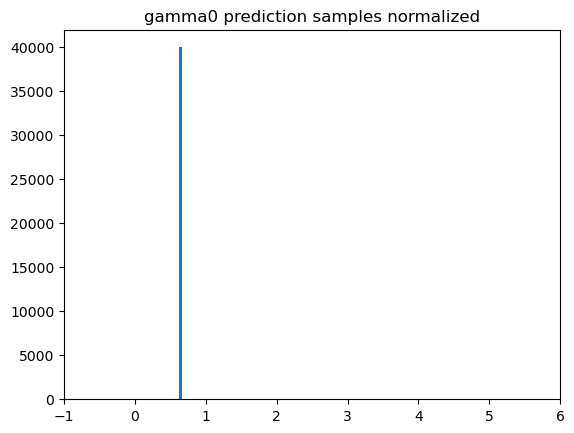

In [96]:
plt.hist(new_predictions[0])
plt.title("gamma0 prediction samples normalized")
plt.xlim(-1, 6)
plt.show()

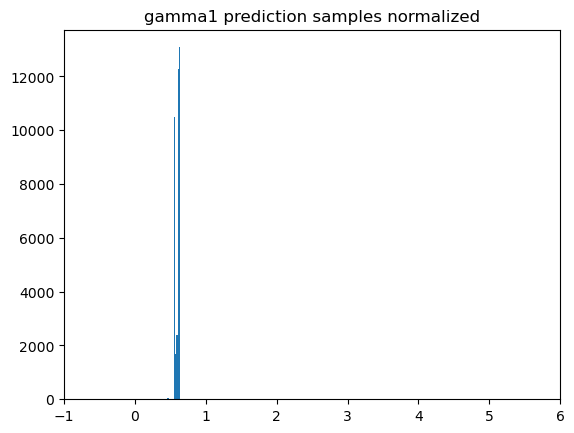

In [97]:
plt.hist(new_predictions[1])
plt.title("gamma1 prediction samples normalized")
plt.xlim(-1, 6)
plt.show()

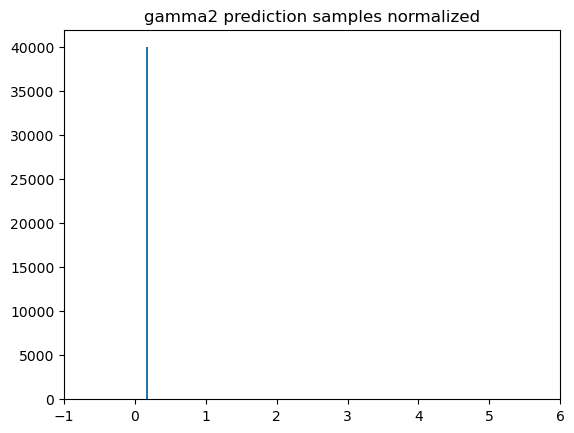

In [98]:
plt.hist(new_predictions[2])
plt.title("gamma2 prediction samples normalized")
plt.xlim(-1, 6)
plt.show()

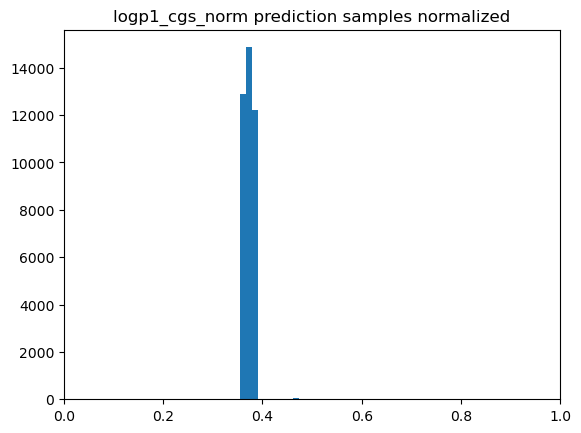

In [99]:
plt.hist(new_predictions[3])
plt.title("logp1_cgs_norm prediction samples normalized")
plt.xlim(0,1)
plt.show()

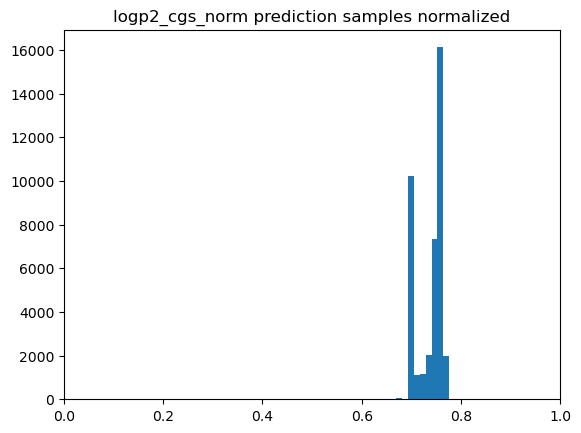

In [100]:
plt.hist(new_predictions[4])
plt.title("logp2_cgs_norm prediction samples normalized")
plt.xlim(0,1)
plt.show()

Histograming un-normalized MLA predictions, still in cgs

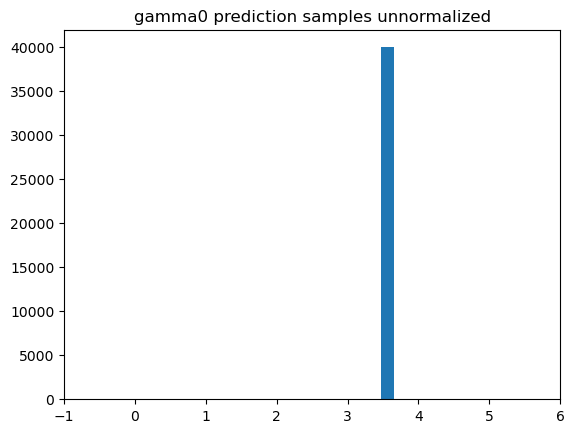

In [101]:
normgam0ar = []
for i in range (len(predictions)):
    normgam0ar.append(predictions[i][0])
plt.hist(normgam0ar)
plt.title("gamma0 prediction samples unnormalized")
plt.xlim(-1, 6)
plt.show()

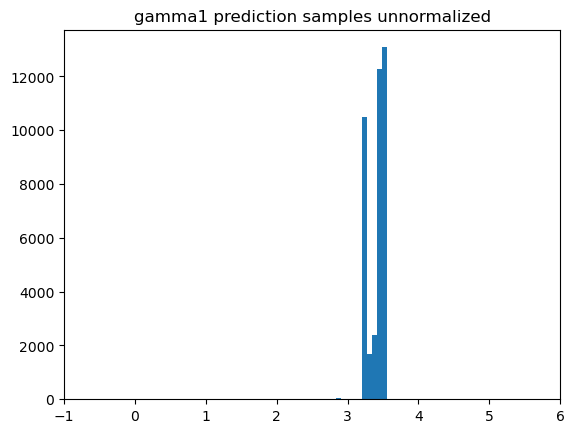

In [102]:
normgam1ar = []
for i in range (len(predictions)):
    normgam1ar.append(predictions[i][1])
plt.hist(normgam1ar)
plt.title("gamma1 prediction samples unnormalized")
plt.xlim(-1, 6)
plt.show()

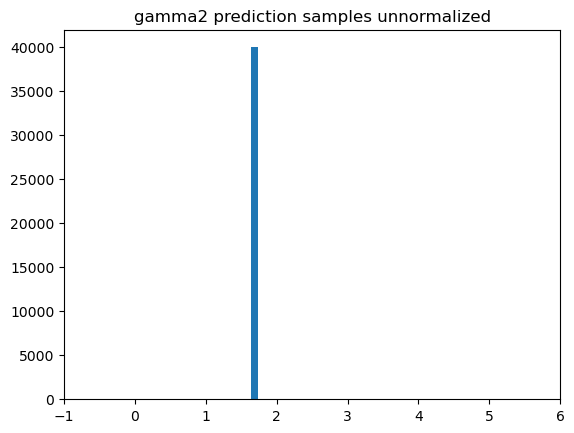

In [103]:
normgam2ar = []
for i in range (len(predictions)):
    normgam2ar.append(predictions[i][2])
plt.hist(normgam2ar)
plt.title("gamma2 prediction samples unnormalized")
plt.xlim(-1, 6)
plt.show()

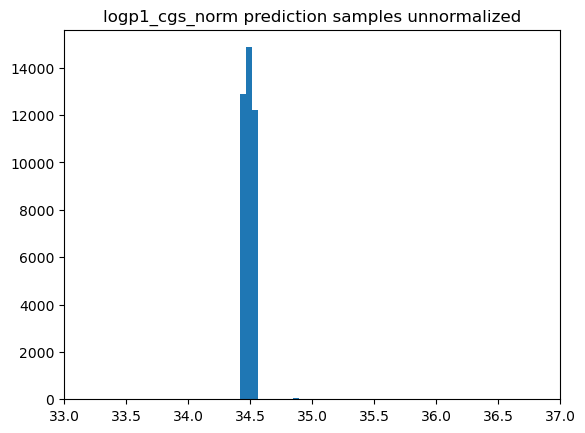

In [104]:
normlogp1ar = []
for i in range (len(predictions)):
    normlogp1ar.append(predictions[i][3])
plt.hist(normlogp1ar)
plt.title("logp1_cgs_norm prediction samples unnormalized")
plt.xlim(33, 37)
plt.show()

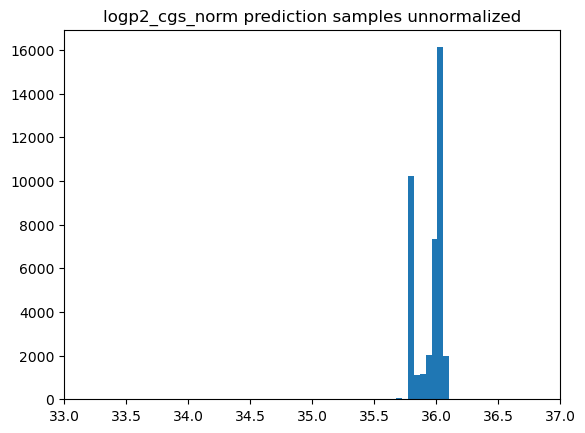

In [105]:
normlogp2ar = []
for i in range (len(predictions)):
    normlogp2ar.append(predictions[i][4])
plt.hist(normlogp2ar)
plt.title("logp2_cgs_norm prediction samples unnormalized")
plt.xlim(33, 37)
plt.show()

# Save to File

In [106]:
train.to_csv('final_df.csv')

In [3]:
df = pd.read_csv('final_df.csv')

# To be moved into a plotting file as a function:

# EOS


Creating many EOS lines, one for each sample and then creating the logpressure log density space with it. Converting when getting p1 and p2 values.

In [ ]:
length = len(predictions)

hlow_0 = 0.022460530117115313 #?
hlow_1 = 0.024210313916473953 #?
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
bad = 0
for i in range(length):
    try: 
        g0 = float(predictions[i][0])
        p1 = float(predictions[i][1] -1)
        g1 = float(predictions[i][2])
        p2 = float(predictions[i][3] -1)
        g2 = float(predictions[i][4])
    
        if i%1000==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.05)
        
    except:
        print("failed")
        bad += 1
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()
print(bad)

Progress : 0 / 40000, 0.00%
failed
failed
failed
failed
failed
Progress : 1000 / 40000, 2.50%


# Actual Values EOS

Re-importing the initial data under different names

In [ ]:
l1 = np.loadtxt('lambda_1-50000.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2-50000.dat.txt', dtype=float)
m1 = np.loadtxt("mass_1_source-50000.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source-50000.dat.txt", dtype=float)

gamma0 = np.loadtxt("eos_polytrope_gamma_0-50000.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1-50000.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2-50000.dat.txt", dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-50000.dat.txt", dtype=float) # in cgs
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-50000.dat.txt", dtype=float) # in cgs

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

# this ends up excluding the last 20% of the data, but is more accurate to represent the MLA predictions because
# the predictions are based off on the first 80% of data. 
length = len(predictions)

Plotting what the EOS should actually look like, using the actual values not the predicted samples by creating an EOS and creating the logpressure & logdensity space.

In [ ]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

A review of all keys used:

In [ ]:
history.history.keys() 

Creating loss graphs:

In [ ]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#loss for logp1_si values
loss_train = history.history['logp1_cgs_norm_output_loss']
loss_val = history.history['val_logp1_cgs_norm_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_cgs_norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#loss for logp2_si values
loss_train = history.history['logp2_cgs_norm_output_loss']
loss_val = history.history['val_logp2_cgs_norm_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_cgs_norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#overall loss
loss_train = history.history['loss']
#loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss overall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()